# Movies recommendation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity


pd.set_option('mode.chained_assignment', None)
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

In [2]:
movies = pd.read_csv("films_details.csv")

In [3]:
movies.head(3)

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_rede...,27 Jan 1998,NaN,Columbia Pictures,NaN,True
1,2,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay), Francis Ford Coppola ...","Marlon Brando, Al Pacino, James Caan, Richard ...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather/,09 Oct 2001,NaN,Paramount Pictures,http://www.thegodfather.com,True
2,3,The Godfather: Part II,1974,R,20 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay), Mario Puzo ...","Al Pacino, Robert Duvall, Diane Keaton, Robert...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather_part...,24 May 2005,NaN,Paramount Pictures,http://www.thegodfather.com/,True


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         250 non-null    int64  
 1   Title              250 non-null    object 
 2   Year               250 non-null    int64  
 3   Rated              250 non-null    object 
 4   Released           248 non-null    object 
 5   Runtime            250 non-null    object 
 6   Genre              250 non-null    object 
 7   Director           250 non-null    object 
 8   Writer             249 non-null    object 
 9   Actors             250 non-null    object 
 10  Plot               250 non-null    object 
 11  Language           250 non-null    object 
 12  Country            250 non-null    object 
 13  Awards             245 non-null    object 
 14  Poster             250 non-null    object 
 15  Ratings.Source     250 non-null    object 
 16  Ratings.Value      250 non

I will use `Title`, `Genre`, `Director`, `Actors` and `Plot`.

In [5]:
df = movies[["Title", "Genre", "Director", "Actors", "Plot"]]

In [6]:
df.head(7)

,Title,Genre,Director,Actors,Plot
0,The Shawshank Redemption,"Crime, Drama",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...
1,The Godfather,"Crime, Drama",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...
2,The Godfather: Part II,"Crime, Drama",Francis Ford Coppola,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",The early life and career of Vito Corleone in ...
3,The Dark Knight,"Action, Crime, Drama",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker emerges fro...
4,12 Angry Men,"Crime, Drama",Sidney Lumet,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",A jury holdout attempts to prevent a miscarria...
5,Schindler's List,"Biography, Drama, History",Steven Spielberg,"Liam Neeson, Ben Kingsley, Ralph Fiennes, Caro...","In German-occupied Poland during World War II,..."
6,The Lord of the Rings: The Return of the King,"Adventure, Drama, Fantasy",Peter Jackson,"Noel Appleby, Ali Astin, Sean Astin, David Aston",Gandalf and Aragorn lead the World of Men agai...


## Text data preprocessing

In [7]:
# preprocessing of Genre, Director and Actors columns
df.loc[:, "Genre"] = df.loc[:, "Genre"].str.lower().str.replace(",", "")
for i in ["Director", "Actors"]:
    df.loc[:, i] = df[i].str.lower().str.replace(" ", "").str.replace(",", " ")

In [8]:
df.head()

,Title,Genre,Director,Actors,Plot
0,The Shawshank Redemption,crime drama,frankdarabont,timrobbins morganfreeman bobgunton williamsadler,Two imprisoned men bond over a number of years...
1,The Godfather,crime drama,francisfordcoppola,marlonbrando alpacino jamescaan richards.caste...,The aging patriarch of an organized crime dyna...
2,The Godfather: Part II,crime drama,francisfordcoppola,alpacino robertduvall dianekeaton robertdeniro,The early life and career of Vito Corleone in ...
3,The Dark Knight,action crime drama,christophernolan,christianbale heathledger aaroneckhart michael...,When the menace known as the Joker emerges fro...
4,12 Angry Men,crime drama,sidneylumet,martinbalsam johnfiedler leej.cobb e.g.marshall,A jury holdout attempts to prevent a miscarria...


In [9]:
# preprocessing of Plot column
df.loc[:, "Plot"] = df["Plot"].str.replace(r'[^\w\s]','', regex=True).str.lower()

def process_text(x):
    non_stop = [token.lemma_ for token in nlp(x) if token.lemma_ not in stopwords]
    return " ".join(non_stop)


df["Plot"] = df["Plot"].apply(lambda x: process_text(x))
df.Plot

0      imprisoned man bond number year find solace ev...
1      age patriarch organize crime dynasty transfer ...
2      early life career vito corleone 1920s new york...
3      menace know joker emerge mysterious past wreak...
4      jury holdout attempt prevent miscarriage justi...
                             ...                        
245    desperate life chronic alcoholic follow fourda...
246    20something supervise staff member residential...
247    newspaper editor use trick book ace reporter e...
248    old man long journey lawnmover tractor mend re...
249    mumbai teen reflect upbringing slum accuse che...
Name: Plot, Length: 250, dtype: object

In [10]:
# cooking soup with all processed text
df["Soup"] = ""

for i in df.columns[1:-1]:
    df["Soup"] += " " + df[i]
    
df.Soup

0       crime drama frankdarabont timrobbins morganfr...
1       crime drama francisfordcoppola marlonbrando a...
2       crime drama francisfordcoppola alpacino rober...
3       action crime drama christophernolan christian...
4       crime drama sidneylumet martinbalsam johnfied...
                             ...                        
245     drama film-noir billywilder raymilland janewy...
246     drama destindanielcretton brielarson johngall...
247     comedy drama romance howardhawks carygrant ro...
248     biography drama davidlynch sissyspacek janega...
249     drama dannyboyle loveleentandan devpatel saur...
Name: Soup, Length: 250, dtype: object

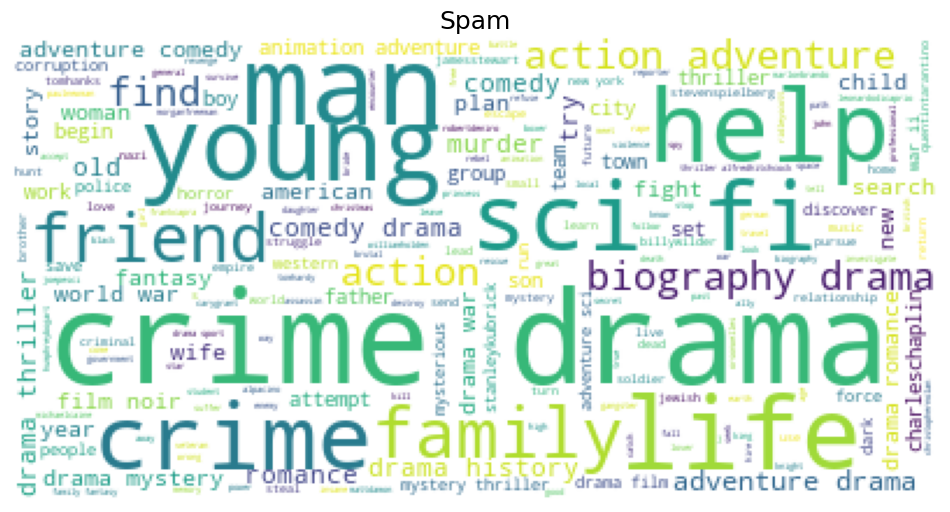

In [11]:
# creating wordcloud
word_cloud = WordCloud(background_color="white").generate(df.Soup.str.cat())

fig, ax = plt.subplots(figsize=(12, 9), facecolor='w')

ax.imshow(word_cloud)
ax.axis("off")
ax.set_title("Spam", fontsize=18)
plt.show()

## Model creation

In [12]:
vec = df["Soup"]

In [13]:
vec_tfidf = TfidfVectorizer().fit_transform(vec)

Cosine similarity will be used to measure the similarity between movies. For vectors $\mathbf{x},\,\mathbf{y}\in\mathbb{R}^n$ it is defined as follows:

$$
d(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}\cdot\mathbf{y}}{\Vert\mathbf{x}\Vert\Vert\mathbf{y}\Vert} = \frac{\sum_{i=1}^n x_i\,y_i }{\Vert\mathbf{x}\Vert\Vert\mathbf{y}\Vert}.
$$

In [14]:
cosine_similarity(vec_tfidf)

array([[1.        , 0.02785546, 0.02585101, ..., 0.00407581, 0.02340881,
        0.00367277],
       [0.02785546, 1.        , 0.17583563, ..., 0.00408701, 0.00398591,
        0.00368287],
       [0.02585101, 0.17583563, 1.        , ..., 0.00379291, 0.00369909,
        0.00341785],
       ...,
       [0.00407581, 0.00408701, 0.00379291, ..., 1.        , 0.00418344,
        0.00386538],
       [0.02340881, 0.00398591, 0.00369909, ..., 0.00418344, 1.        ,
        0.00376976],
       [0.00367277, 0.00368287, 0.00341785, ..., 0.00386538, 0.00376976,
        1.        ]])

We will use `NearestNeighbors` for finding nearest neighors &mdash; most similar movies.

In [15]:
titles = df.Title

def recommend(title, num_of_recommendations=5):
    neigh = NearestNeighbors(n_neighbors=num_of_recommendations + 1, metric="cosine")
    neigh.fit(vec_tfidf)
    chosen_film_index = titles[titles == title].index[0]
    recommendations = neigh.kneighbors(vec_tfidf[chosen_film_index], return_distance=False).flatten()[1:]
    return pd.DataFrame(titles[recommendations])

In [16]:
recommend("The Dark Knight", 5)

,Title
51,The Dark Knight Rises
89,Batman Begins
40,The Prestige
201,Jaws
165,Spider-Man: Homecoming


In [17]:
recommend("The Godfather", 8)

,Title
2,The Godfather: Part II
41,Apocalypse Now
100,On the Waterfront
83,Scarface
194,The Night of the Hunter
110,Casino
199,Guardians of the Galaxy
96,Heat
